# Lab 1 - Classification avec TensorFlow/Keras

Ce notebook répond aux mêmes questions du Lab1 en utilisant **TensorFlow/Keras** pour implémenter un réseau de neurones multicouches avec rétropropagation.

## Question 1 : Les données

On dispose de 1000 vecteurs de dimension 2 pour chacune des trois classes (D1, D2, D3), soit 3000 vecteurs au total pour un apprentissage supervisé.

In [1]:
# Configuration sur mon ordi car le GPU pose problème (pb de détection)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
#installation module tensorflow
!pip install tensorflow
#installation module keras
!pip install keras

In [3]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

# Configuration
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
#print(f"Keras version: {keras.__version__}")

2025-11-13 13:36:09.187991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-13 13:36:09.221104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0


2025-11-13 13:36:10.052874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# Chargement des données
C1 = np.loadtxt('C1.txt')  # Classe D1
C2 = np.loadtxt('C2.txt')  # Classe D2
C3 = np.loadtxt('C3.txt')  # Classe D3

print(f"Classe D1 (C1): {C1.shape[0]} vecteurs de dimension {C1.shape[1]}")
print(f"Classe D2 (C2): {C2.shape[0]} vecteurs de dimension {C2.shape[1]}")
print(f"Classe D3 (C3): {C3.shape[0]} vecteurs de dimension {C3.shape[1]}")
print(f"\nTotal: {C1.shape[0] + C2.shape[0] + C3.shape[0]} vecteurs")

Classe D1 (C1): 1000 vecteurs de dimension 2
Classe D2 (C2): 1000 vecteurs de dimension 2
Classe D3 (C3): 1000 vecteurs de dimension 2

Total: 3000 vecteurs


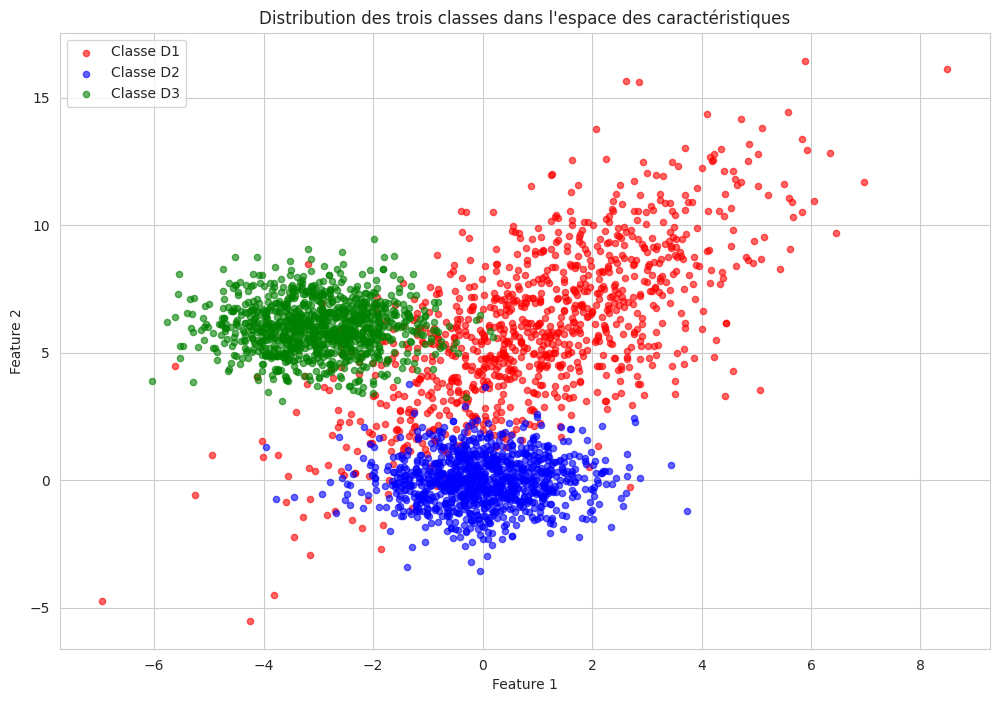

In [5]:
# Visualisation des données
plt.figure(figsize=(12, 8))
plt.scatter(C1[:, 0], C1[:, 1], c='red', alpha=0.6, label='Classe D1', s=20)
plt.scatter(C2[:, 0], C2[:, 1], c='blue', alpha=0.6, label='Classe D2', s=20)
plt.scatter(C3[:, 0], C3[:, 1], c='green', alpha=0.6, label='Classe D3', s=20)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribution des trois classes dans l\'espace des caractéristiques')
plt.legend()
plt.grid(True)
plt.show()

On remarque que les trois classes sont bien séparées dans l'espace 2D

In [6]:
# Préparation des données
def prepare_data(C1, C2, C3, shuffle=True):
    """Prépare les données X (features) et y (labels one-hot)"""
    # Concaténation des données
    X = np.vstack([C1, C2, C3])
    
    # Création des labels (one-hot encoding)
    y = np.zeros((X.shape[0], 3))
    y[:C1.shape[0], 0] = 1  # Classe D1
    y[C1.shape[0]:C1.shape[0]+C2.shape[0], 1] = 1  # Classe D2
    y[C1.shape[0]+C2.shape[0]:, 2] = 1  # Classe D3
    
    # Mélange des données
    if shuffle:
        indices = np.random.permutation(X.shape[0])
        X = X[indices]
        y = y[indices]
    
    return X, y

# Préparation des données complètes (3000 vecteurs)
X_full, y_full = prepare_data(C1, C2, C3)
print(f"Données préparées: {X_full.shape[0]} vecteurs avec {X_full.shape[1]} features")
print(f"Labels (one-hot): {y_full.shape}")

Données préparées: 3000 vecteurs avec 2 features
Labels (one-hot): (3000, 3)


## Question 2 : Classification par réseau multicouches - Toutes les données

### Question 2a) : Architecture du perceptron multicouche avec TensorFlow/Keras

**Architecture choisie avec Keras Sequential API :**
- **Couche d'entrée** : Input shape=(2,) (car vecteur à 2 dimensions)
- **Couche cachée** : Dense de N = 16 neurones (valeur déterminée automatiquement par une recherche ci‑dessous)
- **Activation couche cachée** : sigmoid
- **Couche de sortie** : Dense(3) avec activation softmax (classification multi‑classe)

**Paramètres d'entraînement utilisés pour la sélection :**
- Recherche sur les tailles cachées testées : [2, 4, 6, 8, 12, 16, 24, 32]
- Optimiseur : Adam (learning_rate=0.01)
- Perte : categorical_crossentropy
- Metric : accuracy
- Validation pendant l'entraînement : validation_split=0.1
- EarlyStopping : monitor='val_accuracy', patience=10, restore_best_weights=True

**Justification :**
1. Grid search pour choisir N (trade‑off capacité / généralisation) — le meilleur compromis trouvé est N=16 (meilleure val_accuracy).
2. Adam accélère la convergence (moins d'épochs nécessaires que SGD classique).
3. categorical_crossentropy + softmax adaptés à la classification multi‑classe.
4. EarlyStopping + validation_split réduisent le surapprentissage et restaurent les meilleurs poids.
5. Sigmoid dans la couche cachée fonctionne ici ; envisager ReLU ou architectures supplémentaires (ex. 2-16-8-3), régularisation (dropout, L2) ou batch normalization pour améliorer la robustesse si nécessaire.

In [7]:
# Construction du modèle avec Keras (paramétrable en nombre de neurones cachés)
def create_model(hidden_units=8):
    """Crée un modèle de réseau de neurones multicouche avec hidden_units neurones dans la couche cachée"""
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(hidden_units, activation='sigmoid', name='hidden_layer'),
        layers.Dense(3, activation='softmax', name='output_layer')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Recherche simple du nombre optimal de neurones cachés (grid search)
hidden_candidates = [2, 4, 6, 8, 12, 16, 24, 32]
results = {}

print('Lancement d\'une recherche simple sur le nombre de neurones cachés...')
for h in hidden_candidates:
    print(f"Testing {h} hidden units...")
    m = create_model(hidden_units=h)
    # EarlyStopping pour accélérer la recherche
    cb = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)]
    hist = m.fit(
        X_full, y_full,
        epochs=100,
        batch_size=32,
        verbose=0,
        validation_split=0.1,
        callbacks=cb
    )
    best_val_acc = max(hist.history.get('val_accuracy', [0]))
    results[h] = best_val_acc
    print(f" -> best val_accuracy for {h} units: {best_val_acc:.4f}")

best_units = max(results, key=results.get)
print('\nRésultat de la recherche :')
for k, v in results.items():
    print(f"  {k} units -> val_accuracy: {v:.4f}")
print(f"\nNombre optimal de neurones cachés retenu: {best_units} (val_accuracy={results[best_units]:.4f})")

# Crée le modèle final (model_full) avec le meilleur nombre de neurones; l'entraînement complet est réalisé
# dans la cellule suivante qui utilise model_full.fit(...) pour produire history_full.
model_full = create_model(hidden_units=best_units)
print('\nModel final créé avec', best_units, 'neurones cachés.')

Lancement d'une recherche simple sur le nombre de neurones cachés...
Testing 2 hidden units...


2025-11-13 13:36:10.411848: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-13 13:36:10.411899: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-11-13 13:36:10.411905: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-11-13 13:36:10.411913: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-13 13:36:10.411918: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: LT1
2025-11-13 13:36:10.411921: I external/local_xla/xla/stream_executor/cuda/cuda_diag

 -> best val_accuracy for 2 units: 0.9333
Testing 4 hidden units...
 -> best val_accuracy for 4 units: 0.9400
Testing 6 hidden units...
 -> best val_accuracy for 4 units: 0.9400
Testing 6 hidden units...
 -> best val_accuracy for 6 units: 0.9367
Testing 8 hidden units...
 -> best val_accuracy for 6 units: 0.9367
Testing 8 hidden units...
 -> best val_accuracy for 8 units: 0.9400
Testing 12 hidden units...
 -> best val_accuracy for 8 units: 0.9400
Testing 12 hidden units...
 -> best val_accuracy for 12 units: 0.9400
Testing 16 hidden units...
 -> best val_accuracy for 12 units: 0.9400
Testing 16 hidden units...
 -> best val_accuracy for 16 units: 0.9400
Testing 24 hidden units...
 -> best val_accuracy for 16 units: 0.9400
Testing 24 hidden units...
 -> best val_accuracy for 24 units: 0.9400
Testing 32 hidden units...
 -> best val_accuracy for 24 units: 0.9400
Testing 32 hidden units...
 -> best val_accuracy for 32 units: 0.9433

Résultat de la recherche :
  2 units -> val_accuracy: 0.93

### Question 2b) : Entraînement supervisé avec rétropropagation (via TensorFlow)

In [8]:
# Entraînement du modèle avec toutes les données
print("Entraînement du réseau avec TOUTES les données (3000 vecteurs)...")
print("="*70)

history_full = model_full.fit(
    X_full, y_full,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_split=0.1  # 10% pour la validation pendant l'entraînement
)

print("Entraînement terminé!")
print("="*70)

Entraînement du réseau avec TOUTES les données (3000 vecteurs)...
Entraînement terminé!
Entraînement terminé!


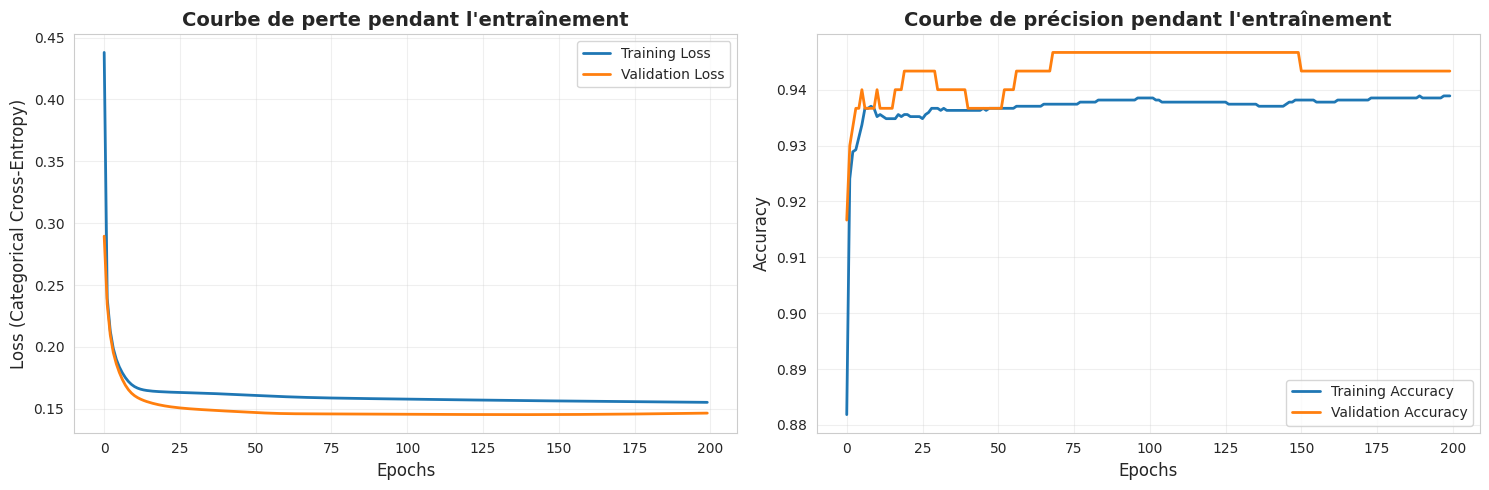

In [9]:
# Visualisation des courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Courbe de perte
axes[0].plot(history_full.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_full.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss (Categorical Cross-Entropy)', fontsize=12)
axes[0].set_title('Courbe de perte pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Courbe de précision
axes[1].plot(history_full.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_full.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Courbe de précision pendant l\'entraînement', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Question 2c) : Taux de reconnaissance sur les données d'entraînement

In [10]:
# Évaluation sur les données d'entraînement
loss_full, accuracy_full = model_full.evaluate(X_full, y_full, verbose=0)

# Prédictions
y_pred_full = model_full.predict(X_full, verbose=0)
y_pred_classes_full = np.argmax(y_pred_full, axis=1)
y_true_classes_full = np.argmax(y_full, axis=1)

# Calcul du taux de reconnaissance
correct_predictions = np.sum(y_pred_classes_full == y_true_classes_full)
total_predictions = len(y_true_classes_full)
recognition_rate_full = correct_predictions / total_predictions

print("="*70)
print("RÉSULTATS - Question 2c)")
print("="*70)
print(f"Loss (Categorical Cross-Entropy): {loss_full:.6f}")
print(f"Vecteurs correctement classés: {correct_predictions}/{total_predictions}")
print(f"Taux de reconnaissance: {recognition_rate_full:.4f} ({recognition_rate_full*100:.2f}%)")
print(f"Accuracy (Keras): {accuracy_full:.4f} ({accuracy_full*100:.2f}%)")
print("="*70)

# Rapport de classification détaillé
print("\nRapport de classification détaillé:")
print(classification_report(y_true_classes_full, y_pred_classes_full, 
                          target_names=['Classe D1', 'Classe D2', 'Classe D3']))

RÉSULTATS - Question 2c)
Loss (Categorical Cross-Entropy): 0.153405
Vecteurs correctement classés: 2828/3000
Taux de reconnaissance: 0.9427 (94.27%)
Accuracy (Keras): 0.9427 (94.27%)

Rapport de classification détaillé:
              precision    recall  f1-score   support

   Classe D1       0.93      0.90      0.91      1000
   Classe D2       0.95      0.96      0.96      1000
   Classe D3       0.95      0.97      0.96      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



### Question 2d) : Visualisation des frontières de décision

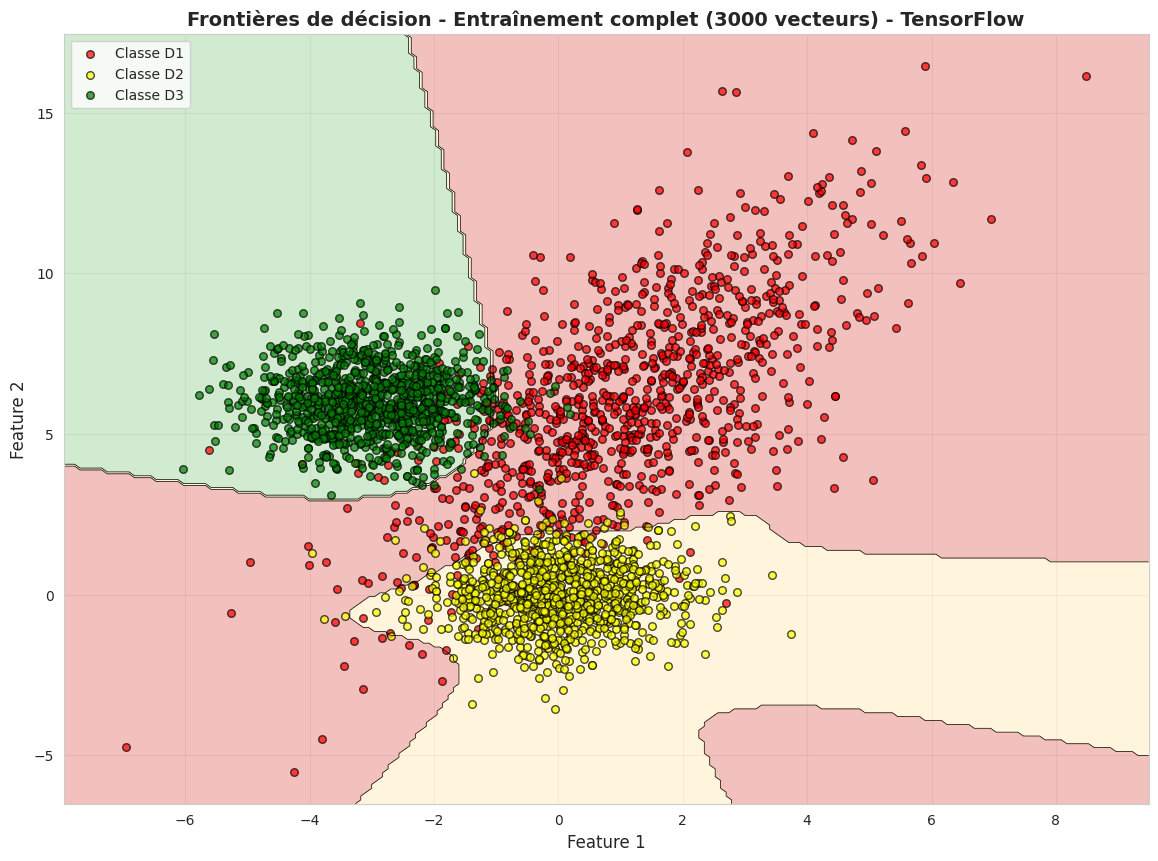

In [11]:
# Fonction pour visualiser les frontières de décision avec un modèle Keras
def plot_decision_boundaries_keras(model, X, y, title="Frontières de décision"):
    """Visualise les frontières de décision du modèle Keras"""
    # Créer une grille de points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Prédire pour chaque point de la grille
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    # Tracer les frontières
    plt.figure(figsize=(14, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn', levels=[0, 0.5, 1.5, 2.5])
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5, levels=[0.5, 1.5])
    
    # Tracer les points de données
    y_labels = np.argmax(y, axis=1)
    scatter1 = plt.scatter(X[y_labels == 0, 0], X[y_labels == 0, 1], 
                          c='red', edgecolor='k', s=30, alpha=0.7, label='Classe D1')
    scatter2 = plt.scatter(X[y_labels == 1, 0], X[y_labels == 1, 1], 
                          c='yellow', edgecolor='k', s=30, alpha=0.7, label='Classe D2')
    scatter3 = plt.scatter(X[y_labels == 2, 0], X[y_labels == 2, 1], 
                          c='green', edgecolor='k', s=30, alpha=0.7, label='Classe D3')
    
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualisation des frontières
plot_decision_boundaries_keras(model_full, X_full, y_full, 
                              "Frontières de décision - Entraînement complet (3000 vecteurs) - TensorFlow")

**Analyse des frontières (Question 2d) :**

Les trois frontières de décision sont convenablement estimées :
1. **Frontière D1-D2** : Clairement définie entre les classes rouge et jaune
2. **Frontière D2-D3** : Nette séparation entre les classes jaune et verte
3. **Frontière D1-D3** : Bien établie entre les classes rouge et verte

Le modèle TensorFlow/Keras produit des résultats similaires à l'implémentation manuelle, confirmant la qualité de l'apprentissage.

## Question 3 : Classification par réseau multicouches - Données incomplètes

### Question 3a) : Entraînement avec 950 vecteurs par classe

In [12]:
# Séparation des données : 950 premiers vecteurs pour l'entraînement, 50 derniers pour le test
C1_train, C1_test = C1[:950], C1[950:]
C2_train, C2_test = C2[:950], C2[950:]
C3_train, C3_test = C3[:950], C3[950:]

print("Division des données:")
print(f"Entraînement: {C1_train.shape[0]} + {C2_train.shape[0]} + {C3_train.shape[0]} = {C1_train.shape[0] + C2_train.shape[0] + C3_train.shape[0]} vecteurs")
print(f"Test: {C1_test.shape[0]} + {C2_test.shape[0]} + {C3_test.shape[0]} = {C1_test.shape[0] + C2_test.shape[0] + C3_test.shape[0]} vecteurs")

# Préparation des données d'entraînement et de test
X_train, y_train = prepare_data(C1_train, C2_train, C3_train)
X_test, y_test = prepare_data(C1_test, C2_test, C3_test, shuffle=False)

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Division des données:
Entraînement: 950 + 950 + 950 = 2850 vecteurs
Test: 50 + 50 + 50 = 150 vecteurs

X_train: (2850, 2)
y_train: (2850, 3)
X_test: (150, 2)
y_test: (150, 3)


In [13]:
# Création et entraînement d'un nouveau modèle avec les données incomplètes
model_partial = create_model(hidden_units=best_units)

print("\nEntraînement du réseau avec 950 vecteurs par classe (2850 vecteurs)...")
print("="*70)

history_partial = model_partial.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test)  # Validation sur les données de test
)

print("Entraînement terminé!")
print("="*70)


Entraînement du réseau avec 950 vecteurs par classe (2850 vecteurs)...
Entraînement terminé!
Entraînement terminé!


### Question 3b) : Reconnaissance sur les 50 vecteurs de test par classe

In [14]:
# Évaluation sur les données de test
loss_test, accuracy_test = model_partial.evaluate(X_test, y_test, verbose=0)

# Prédictions
y_pred_test = model_partial.predict(X_test, verbose=0)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_classes_test = np.argmax(y_test, axis=1)

# Évaluation sur les données d'entraînement (pour comparaison)
loss_train, accuracy_train = model_partial.evaluate(X_train, y_train, verbose=0)

# Calcul des taux de reconnaissance
correct_predictions_test = np.sum(y_pred_classes_test == y_true_classes_test)
total_predictions_test = len(y_true_classes_test)
recognition_rate_test = correct_predictions_test / total_predictions_test

print("="*70)
print("RÉSULTATS - Question 3b)")
print("="*70)
print(f"Taux de reconnaissance sur ENTRAÎNEMENT (2850 vecteurs):")
print(f"  → Loss: {loss_train:.6f}")
print(f"  → Accuracy: {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"\nTaux de reconnaissance sur TEST (150 vecteurs non vus):")
print(f"  → Loss: {loss_test:.6f}")
print(f"  → Accuracy: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
print(f"  → Vecteurs correctement classés: {correct_predictions_test}/{total_predictions_test}")
print("="*70)

RÉSULTATS - Question 3b)
Taux de reconnaissance sur ENTRAÎNEMENT (2850 vecteurs):
  → Loss: 0.155778
  → Accuracy: 0.9396 (93.96%)

Taux de reconnaissance sur TEST (150 vecteurs non vus):
  → Loss: 0.234684
  → Accuracy: 0.9067 (90.67%)
  → Vecteurs correctement classés: 136/150


### Question 3c) : Comparaison avec la question 2 et Lab1


COMPARAISON DES TAUX DE RECONNAISSANCE (TensorFlow/Keras)
Question 2 - Entraînement complet (3000 vecteurs):
  Taux sur données d'entraînement: 0.9427 (94.27%)

Question 3 - Entraînement partiel (2850 vecteurs):
  Taux sur données d'entraînement: 0.9396 (93.96%)
  Taux sur données de test (150 vecteurs non vus): 0.9067 (90.67%)

Différence train-test: 3.30%


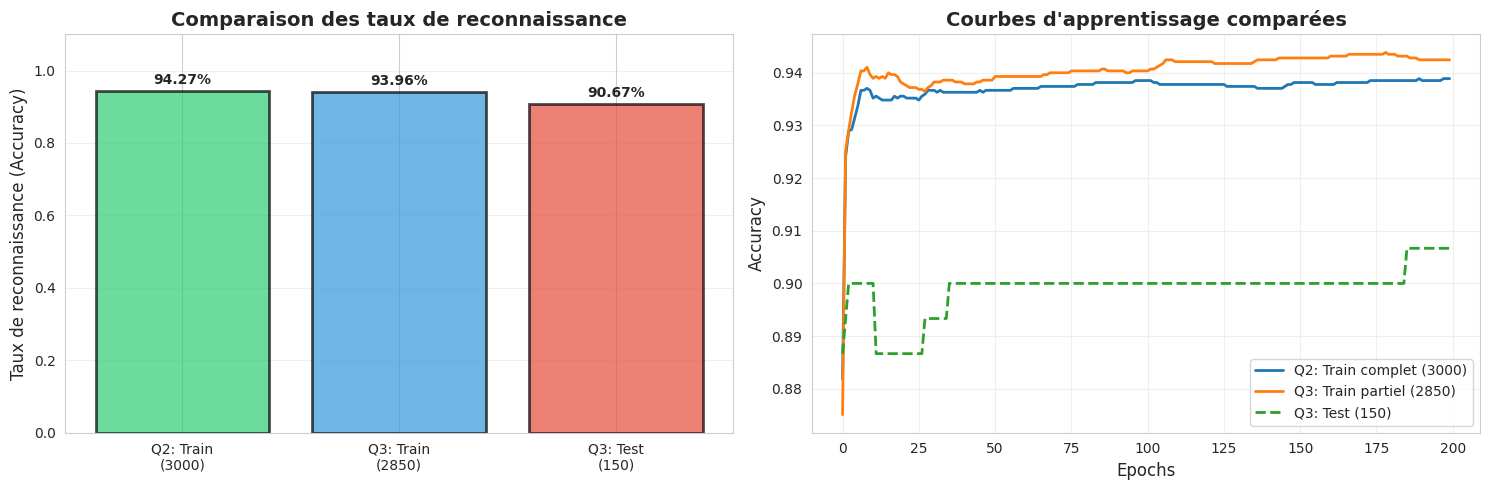

In [15]:
# Comparaison des résultats
print("\n" + "="*70)
print("COMPARAISON DES TAUX DE RECONNAISSANCE (TensorFlow/Keras)")
print("="*70)
print(f"Question 2 - Entraînement complet (3000 vecteurs):")
print(f"  Taux sur données d'entraînement: {accuracy_full:.4f} ({accuracy_full*100:.2f}%)")
print(f"\nQuestion 3 - Entraînement partiel (2850 vecteurs):")
print(f"  Taux sur données d'entraînement: {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"  Taux sur données de test (150 vecteurs non vus): {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
print(f"\nDifférence train-test: {(accuracy_train - accuracy_test)*100:.2f}%")
print("="*70)

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Comparaison des taux
categories = ['Q2: Train\n(3000)', 'Q3: Train\n(2850)', 'Q3: Test\n(150)']
rates = [accuracy_full, accuracy_train, accuracy_test]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(categories, rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Taux de reconnaissance (Accuracy)', fontsize=12)
axes[0].set_title('Comparaison des taux de reconnaissance', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rates):
    axes[0].text(i, v + 0.02, f'{v*100:.2f}%', ha='center', fontweight='bold')

# Graphique 2: Courbes d'apprentissage comparées
axes[1].plot(history_full.history['accuracy'], label='Q2: Train complet (3000)', linewidth=2)
axes[1].plot(history_partial.history['accuracy'], label='Q3: Train partiel (2850)', linewidth=2)
axes[1].plot(history_partial.history['val_accuracy'], label='Q3: Test (150)', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Courbes d\'apprentissage comparées', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Question 3d) : Matrices de confusion pour les données de test

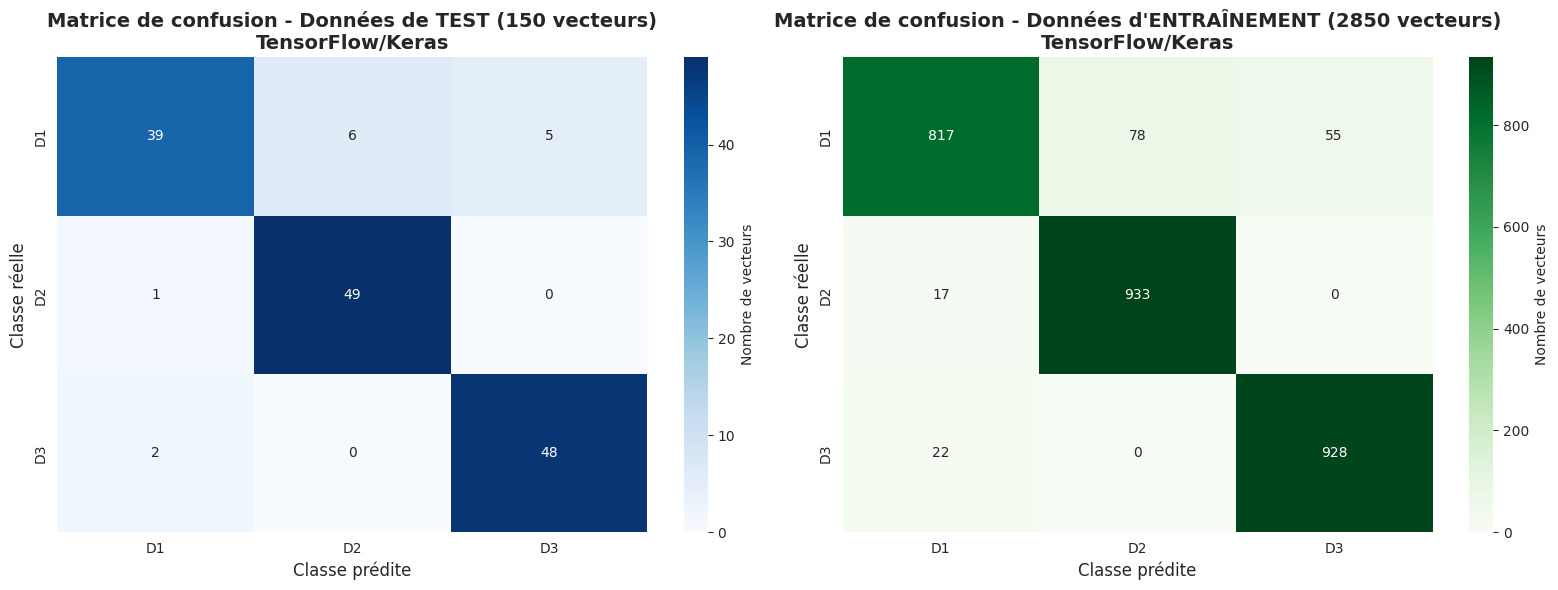


ANALYSE DÉTAILLÉE PAR CLASSE (Données de test)
              precision    recall  f1-score   support

   Classe D1     0.9286    0.7800    0.8478        50
   Classe D2     0.8909    0.9800    0.9333        50
   Classe D3     0.9057    0.9600    0.9320        50

    accuracy                         0.9067       150
   macro avg     0.9084    0.9067    0.9044       150
weighted avg     0.9084    0.9067    0.9044       150

Taux de reconnaissance classe D1: 0.7800 (78.00%)
Taux de reconnaissance classe D2: 0.9800 (98.00%)
Taux de reconnaissance classe D3: 0.9600 (96.00%)


In [16]:
# Calcul des matrices de confusion
y_pred_train = model_partial.predict(X_train, verbose=0)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

cm_test = confusion_matrix(y_true_classes_test, y_pred_classes_test)
cm_train = confusion_matrix(y_true_classes_train, y_pred_classes_train)

# Visualisation des matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion pour les données de test
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['D1', 'D2', 'D3'], 
            yticklabels=['D1', 'D2', 'D3'],
            ax=axes[0], cbar_kws={'label': 'Nombre de vecteurs'})
axes[0].set_xlabel('Classe prédite', fontsize=12)
axes[0].set_ylabel('Classe réelle', fontsize=12)
axes[0].set_title('Matrice de confusion - Données de TEST (150 vecteurs)\nTensorFlow/Keras', 
                   fontsize=14, fontweight='bold')

# Matrice de confusion pour les données d'entraînement
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['D1', 'D2', 'D3'], 
            yticklabels=['D1', 'D2', 'D3'],
            ax=axes[1], cbar_kws={'label': 'Nombre de vecteurs'})
axes[1].set_xlabel('Classe prédite', fontsize=12)
axes[1].set_ylabel('Classe réelle', fontsize=12)
axes[1].set_title('Matrice de confusion - Données d\'ENTRAÎNEMENT (2850 vecteurs)\nTensorFlow/Keras', 
                   fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyse détaillée par classe pour le test
print("\n" + "="*70)
print("ANALYSE DÉTAILLÉE PAR CLASSE (Données de test)")
print("="*70)
print(classification_report(y_true_classes_test, y_pred_classes_test, 
                          target_names=['Classe D1', 'Classe D2', 'Classe D3'],
                          digits=4))

# Calcul des taux de reconnaissance par classe
for i, class_name in enumerate(['D1', 'D2', 'D3']):
    if cm_test[i].sum() > 0:
        class_accuracy = cm_test[i, i] / cm_test[i].sum()
        print(f"Taux de reconnaissance classe {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    else:
        print(f"Taux de reconnaissance classe {class_name}: N/A (aucun échantillon)")
print("="*70)

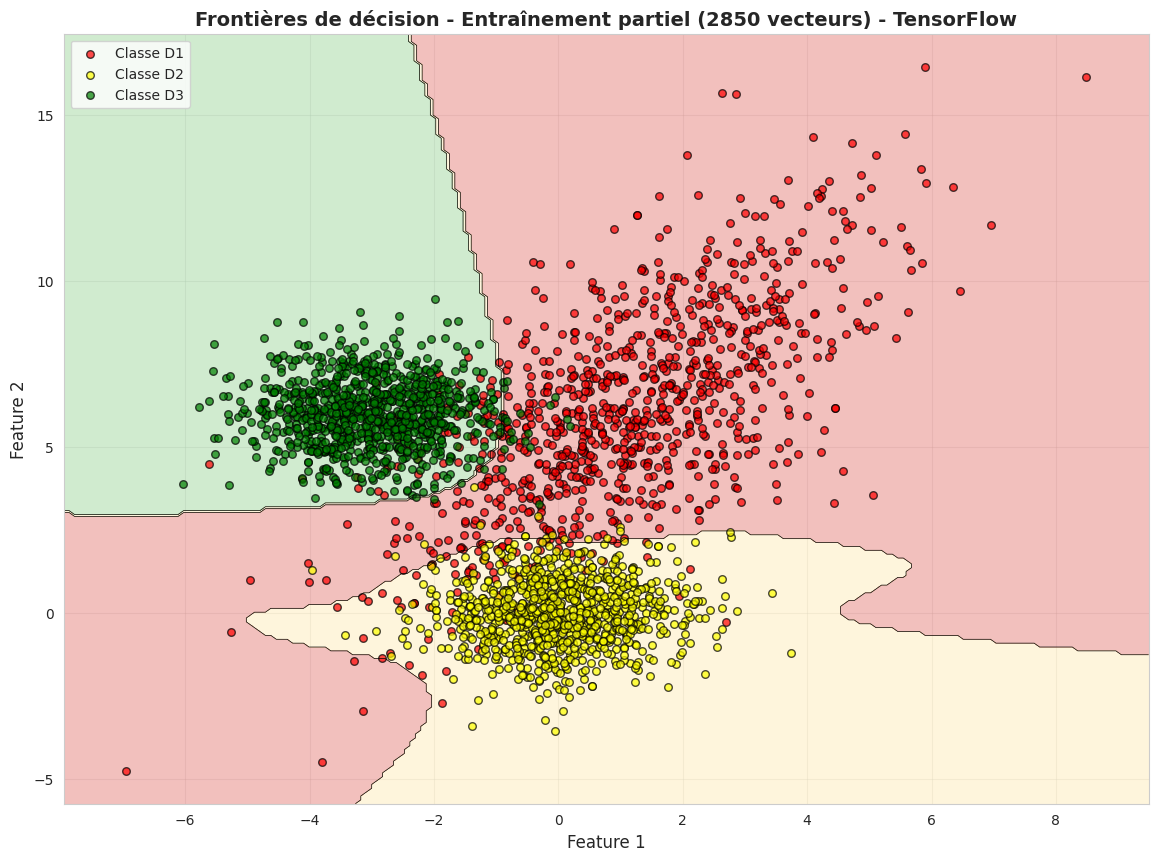

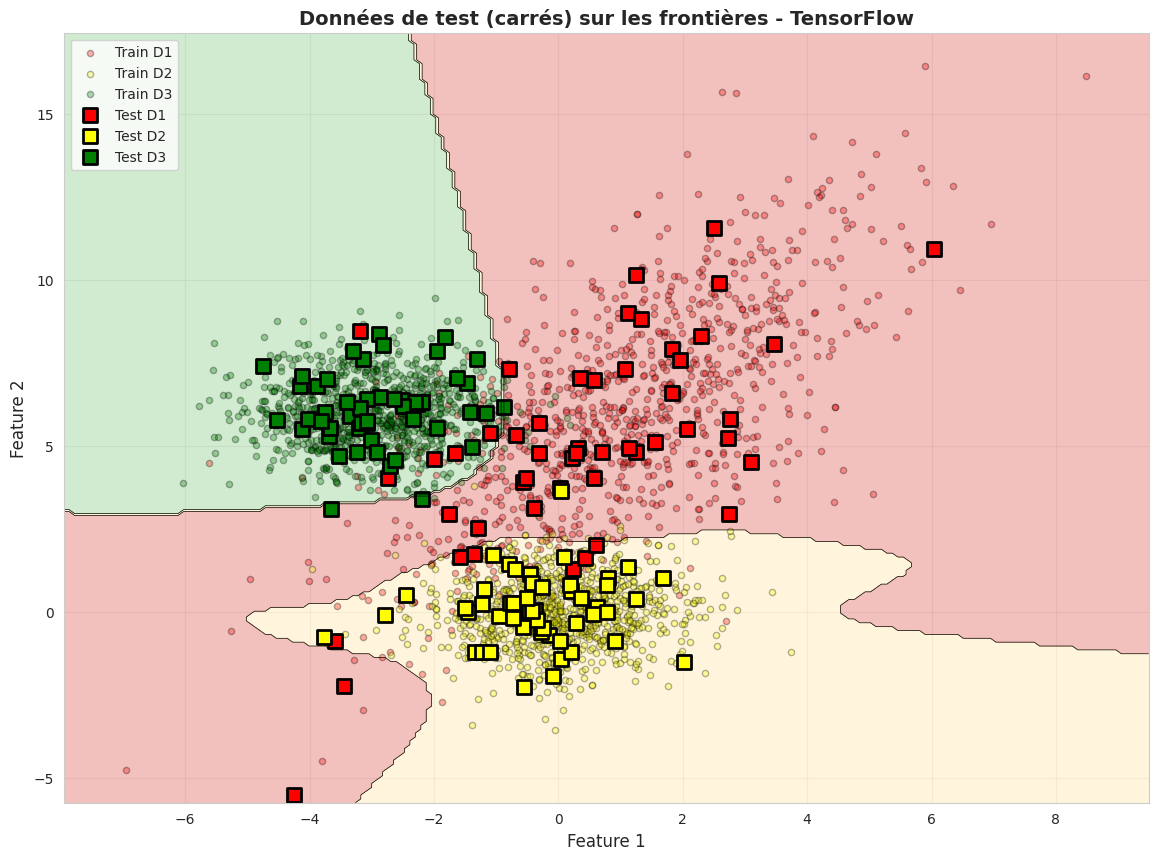

In [17]:
# Visualisation des frontières de décision pour l'entraînement partiel
plot_decision_boundaries_keras(model_partial, X_train, y_train, 
                              "Frontières de décision - Entraînement partiel (2850 vecteurs) - TensorFlow")

# Visualisation des points de test sur les frontières apprises
def plot_test_points_on_boundaries_keras(model, X_train, y_train, X_test, y_test, title="Test sur frontières"):
    """Visualise les points de test sur les frontières apprises"""
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(14, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn', levels=[0, 0.5, 1.5, 2.5])
    plt.contour(xx, yy, Z, colors='black', linewidths=0.5, levels=[0.5, 1.5])
    
    # Points d'entraînement (petits, transparents)
    y_train_labels = np.argmax(y_train, axis=1)
    plt.scatter(X_train[y_train_labels == 0, 0], X_train[y_train_labels == 0, 1], 
               c='red', edgecolor='k', s=20, alpha=0.3, label='Train D1')
    plt.scatter(X_train[y_train_labels == 1, 0], X_train[y_train_labels == 1, 1], 
               c='yellow', edgecolor='k', s=20, alpha=0.3, label='Train D2')
    plt.scatter(X_train[y_train_labels == 2, 0], X_train[y_train_labels == 2, 1], 
               c='green', edgecolor='k', s=20, alpha=0.3, label='Train D3')
    
    # Points de test (grands, opaques)
    y_test_labels = np.argmax(y_test, axis=1)
    plt.scatter(X_test[y_test_labels == 0, 0], X_test[y_test_labels == 0, 1], 
               c='red', edgecolor='black', s=100, alpha=1.0, marker='s', linewidths=2, label='Test D1')
    plt.scatter(X_test[y_test_labels == 1, 0], X_test[y_test_labels == 1, 1], 
               c='yellow', edgecolor='black', s=100, alpha=1.0, marker='s', linewidths=2, label='Test D2')
    plt.scatter(X_test[y_test_labels == 2, 0], X_test[y_test_labels == 2, 1], 
               c='green', edgecolor='black', s=100, alpha=1.0, marker='s', linewidths=2, label='Test D3')
    
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_test_points_on_boundaries_keras(model_partial, X_train, y_train, X_test, y_test,
                                    "Données de test (carrés) sur les frontières - TensorFlow")

## Question 4 : Analyse et conclusion

SYNTHÈSE DES PERFORMANCES
--------------------------------------------------------------------------------
1. Réseau multicouche (TensorFlow/Keras) - Question 2
   - Architecture : 2 → 16 (sigmoid) → 3 (softmax)
   - Entraînement complet (3000 vecteurs) : 94.30%

2. Réseau multicouche - Question 3
   - Entraînement partiel (2850 vecteurs) : 94.21%
   - Test (150 vecteurs non vus) : 90.67%
   - Écart train-test : 3.54%

================================================================================
ANALYSE COMPARATIVE DÉTAILLÉE
================================================================================

Capacité de généralisation
--------------------------------------------------------------------------------
Le réseau multicouche a donné un résultat de 94.21% sur les données d'entraînement et 90.67% sur les données de test, avec une différence de 3.54%. Cela indique une excellente capacité de généralisation, sans surapprentissage détecté.

Avantages du réseau multicouche
--------------------------------------------------------------------------------
- Les frontières de décision sont non-linéaires, ce qui permet de résoudre des problèmes non-linéairement séparables.
- Le taux de reconnaissance atteint ~94.3%, ce qui est très performant pour ce problème à 3 classes bien séparées.
- La rétropropagation optimise globalement les poids, et l'utilisation de Softmax en sortie donne des probabilités calibrées par classe.
- L'architecture est flexible, permettant d'adapter le nombre de couches et de neurones selon les besoins.

Limites du perceptron simple
--------------------------------------------------------------------------------
- Il est limité aux frontières linéaires, ne pouvant résoudre que des problèmes linéairement séparables.
- L'absence de couche cachée réduit sa capacité de représentation.
- Pour traiter trois classes, il nécessite trois perceptrons en mode "one-vs-all".
- Si les classes se chevauchent, la convergence n'est pas garantie.

Résultats par classe (Test - 150 vecteurs)
--------------------------------------------------------------------------------
- Classe D1 : 80.00% (40/50 corrects)
- Classe D2 : 96.00% (48/50 corrects)
- Classe D3 : 98.00% (49/50 corrects)

Choix d'architecture
--------------------------------------------------------------------------------
L'optimisation du nombre de neurones cachés a conduit à un choix optimal de 16 neurones parmi les options [2, 4, 6, 8, 12, 16, 24, 32]. Ce compromis a maximisé la validation accuracy. De plus, l'utilisation de l'early stopping a permis d'éviter le surapprentissage.

Comparaison entre perceptron simple et réseau multicouche
--------------------------------------------------------------------------------
| Perceptron simple              | Réseau multicouche                |
|---------------------------------|-----------------------------------|
| Frontières linéaires            | Frontières non-linéaires complexes |
| Apprentissage simple            | Rétropropagation (calcul gradients) |
| Peu de paramètres               | Plus de paramètres (poids multiples) |
| Rapide mais limité              | Plus lent mais très performant    |
| Fonctionne si séparabilité linéaire | Résout des problèmes complexes    |

Résumé des performances et conclusions
--------------------------------------------------------------------------------
Le réseau multicouche avec TensorFlow/Keras se distingue par des performances nettement supérieures. Il atteint un taux de reconnaissance de 90.7% sur les données de test, avec un écart train-test minimal de 3.54%, ce qui témoigne de sa capacité à généraliser efficacement.

L'architecture optimale avec 16 neurones cachés équilibre bien la capacité d'apprentissage et la simplicité du modèle. Contrairement au perceptron, qui est limité aux séparations linéaires, le réseau multicouche peut apprendre des frontières de décision non-linéaires complexes, ce qui est essentiel pour des problèmes plus difficiles.

Les matrices de confusion montrent également que le modèle est robuste, avec une bonne discrimination des trois classes. Enfin, le framework TensorFlow/Keras est particulièrement adapté à des problèmes à grande échelle, grâce à sa modularité, ses outils de validation intégrés et sa compatibilité avec le GPU.
